In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
tqdm.monitor_interval = 0

In [3]:
FORECAST = 5

In [4]:
dset = Routes('train', 16, index_file='min-data.json')
evalset = Routes('test', 32, index_file='min-data.json')

Routes dataset: train
 [*] Loaded routes: 224 (0.28s)
 [*] Subset train: 204 (reserved_routes.json)
 [*] Loaded trainable inds: 240935 (0.20s)
Routes dataset: test
 [*] Loaded routes: 224 (0.30s)
 [*] Subset test: 20 (reserved_routes.json)
 [*] Loaded trainable inds: 54181 (0.02s)


In [5]:
import torch
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
from models.RNN2 import RNN2

In [16]:
model = RNN2(forecast=FORECAST).to(device)

In [9]:
criterion, opt, sch = model.params(lr=0.001)

In [13]:
def evaluate():
    eval_losses = []
    for bii in range(evalset.size()):
        model.eval()
        
        Xs, Ys = evalset.next()
        Xs, Ys = model.format_batch(Xs, Ys, gpu=device)

        outputs = model(Xs)
        loss = criterion(outputs, Ys)
        eval_losses.append(loss.item())
        sys.stdout.write('eval:%d/%d     \r' % (bii+1, evalset.size()))
    sys.stdout.flush()
    print('Eval loss:', np.mean(eval_losses))

In [14]:
evaluate()

Eval loss: 27.56709207618159


In [17]:
EPS = 5
losses = []
for eii  in range(EPS):
    for bii in range(dset.size()):
        model.train()
        Xs, Ys = dset.next()
        Xs, Ys = model.format_batch(Xs, Ys, gpu=device)

        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, dset.size(), 
            loss.item()
        ))
    sys.stdout.write('\n')
    evaluate()
    torch.save(model.state_dict(), 'checkpoints/%s_e%d.pth' % (model.name, eii+1))
    sys.stdout.flush()
    sch.step()
#     sys.stdout.flush()

KeyboardInterrupt: 

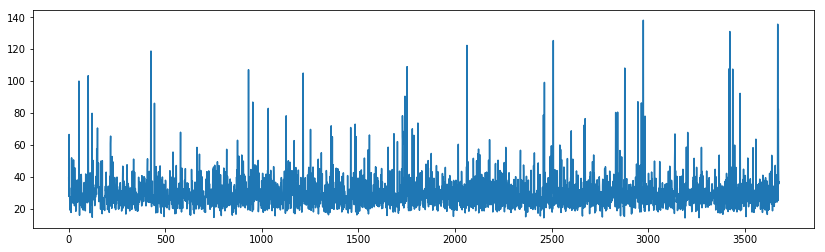

In [18]:
plt.figure(figsize=(14, 4))
plt.plot(losses)
plt.show();plt.close()

In [19]:
_ = model.eval()

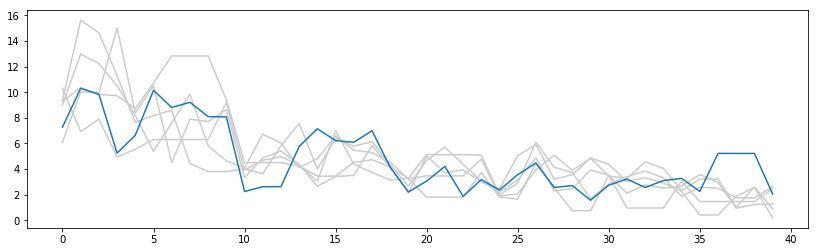

In [20]:
info = evalset.meta[0]
len(info['trainable'])
data = history_byname(info['name'])

row_integs = []
for row in data:
    row_integs.append(np.count_nonzero(np.isnan(row)) / len(row))
ind = np.argsort(row_integs)[0]
sample = data[ind-6:ind, :]

plt.figure(figsize=(14, 4))
for hi in range(1, 6):
    plt.plot(sample[-hi-1, :], color='#CCCCCC')
plt.plot(sample[-1, :], color='C0')
plt.show(); plt.close()

In [21]:
preds = []
for bi in range(10, sample.shape[1]):
# for bi in range(10, sample.shape[1]):
    Xs, Ys = np.array([sample[:5, bi-10:bi]]), np.array([sample[5, bi-10:bi]])
    Xs, Ys = model.format_batch(Xs, Ys, gpu=device)
    Yguess = model(Xs)
    ys = Yguess.detach().squeeze().cpu().numpy()
    ys = np.flip(ys).copy()
    preds.append(ys)

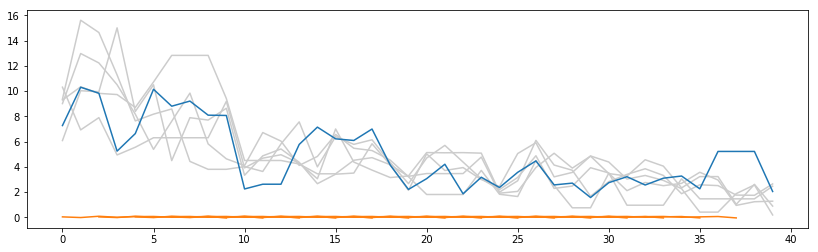

In [22]:
plt.figure(figsize=(14, 4))
for hi in range(1, 6):
    plt.plot(sample[-hi-1, :], color='#CCCCCC')
plt.plot(sample[-1, :], color='C0')
# for bi in range(10, sample.shape[1], 2):
for bi in range(10, sample.shape[1], 2):
    plt.plot(range(bi-10, bi), preds[bi-10], color='C1')
#     plt.plot(range(bi-10, bi-5), preds[bi-10][:5], color='C1')
plt.show(); plt.close()